# Beispiel: MNIST Data

Wir trainieren ein Modell um handgeschriebene Ziffern zu erkennen:

#### Importieren der Abhängigkeiten

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Flatten, Conv2D, MaxPooling2D)
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import os
import shutil

#### Laden der Daten

In [2]:
(X_train_in, y_train_in), (X_test_in, y_test_in) = mnist.load_data()

### Plotten der Daten

In [3]:
def plot_random_datapoint():
    sample = np.random.randint(0, X_train_in.shape[0])

    plt.figure(figsize = (10,10))
    mnist_img = X_train_in[sample]
    plt.imshow(mnist_img, cmap="Greys")

    # Get the `Axes` instance on the current figure
    ax = plt.gca()

    plt.tick_params(
        axis='both', which='major', bottom=True, left=True,
        labelbottom=False, labelleft=False)

    plt.tick_params(
        axis='both', which='minor', bottom=False, left=False,
        labelbottom=True, labelleft=True)

    ax.set_xticks(np.arange(-.5, 28, 1))
    ax.set_yticks(np.arange(-.5, 28, 1))

    ax.set_xticks(np.arange(0, 28, 1), minor=True);
    ax.set_xticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);
    ax.set_yticks(np.arange(0, 28, 1), minor=True);
    ax.set_yticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);

    ax.grid(color='black', linestyle='-', linewidth=1.5)
    plt.colorbar(fraction=0.046, pad=0.04, ticks=[0,32,64,96,128,160,192,224,255])

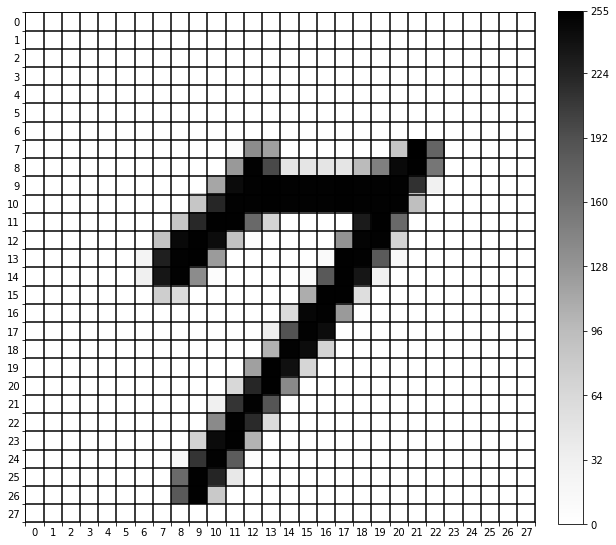

In [4]:
plot_random_datapoint()

#### Preprocessing der Daten

In [5]:
def preprocess_data(data):
    reshaped_data = data.reshape(-1, 28, 28, 1)
    float_data = reshaped_data.astype('float32')
    return float_data / 255.0


In [6]:
X_train = preprocess_data(X_train_in)
X_test = preprocess_data(X_test_in)

In [7]:
X_train.shape, X_test.shape


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
min(y_train_in), max(y_train_in)

(0, 9)

In [9]:
n_classes = max(y_train_in) + 1
y_train = to_categorical(y_train_in, n_classes)
y_test = to_categorical(y_test_in, n_classes)

In [10]:
y_train_in[0], y_test_in[0]

(5, 7)

In [11]:
y_train[0], y_test[0]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

Reduziere die Größe der Trainingsdaten um den Effekt von zu wenigen Daten zu illustrieren:

In [12]:
X_train_medium = X_train[:6000, :]
y_train_medium = y_train[:6000]
X_train_small = X_train[:600, :]
y_train_small = y_train[:600]
X_train_tiny = X_train[:120, :]
y_train_tiny = y_train[:120]
print(f"X_train has        {X_train.shape[0]:6} samples.")
print(f"X_train_medium has {X_train_medium.shape[0]:6} samples.")
print(f"X_train_small has  {X_train_small.shape[0]:6} samples.")
print(f"X_train_tiny has   {X_train_tiny.shape[0]:6} samples.")

X_train has         60000 samples.
X_train_medium has   6000 samples.
X_train_small has     600 samples.
X_train_tiny has      120 samples.


In [13]:
def create_model():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(n_classes, activation='softmax')
        ])
    return model

### Instanziieren der Modelle

Wir instanziieren ein Modell für jeden Trainingsdatensatz um verfolgen zu
können, wie gut die Modelle lernen.

In [14]:
model_tiny = create_model()
model_small = create_model()
model_medium = create_model()
model_large = create_model()

In [15]:
model_large.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Kompilieren der Modelle

In [16]:
model_tiny.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy',
                            Precision(class_id=0, name='precision'),
                            Recall(class_id=0, name='recall')])
model_small.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                             Precision(class_id=0, name='precision'),
                             Recall(class_id=0, name='recall')])
model_medium.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy',
                              Precision(class_id=0, name='precision'),
                              Recall(class_id=0, name='recall')])
model_large.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                             Precision(class_id=0, name='precision'),
                             Recall(class_id=0, name='recall')])

#### Löschen des TensorBoard Verzeichnisses

In [17]:
shutil.rmtree('logs', True)
os.mkdir('logs')

#### Trainieren!

In [18]:
def train_model(model, X_train, y_train, tensor_board_suffix, epochs=40):
    os.mkdir(f'logs/deep-net{tensor_board_suffix}')
    os.mkdir(f'logs/deep-net{tensor_board_suffix}/train')
    tensorboard = TensorBoard(f'logs/deep-net-{tensor_board_suffix}')
    model.fit(X_train, y_train,
              batch_size=min(X_train.shape[0]//2, 100) ,
              epochs=epochs, verbose=1,
              validation_data=(X_test, y_test),
              callbacks=[tensorboard])

In [19]:
train_model(model_tiny, X_train_tiny, y_train_tiny, 'tiny')

Epoch 1/40
1/2 [==============>...............] - ETA: 0s - loss: 2.3369 - accuracy: 0.1000 - precision: 0.0000e+00 - recall: 0.0000e+00WARNING:tensorflow:From c:\users\tc\.venv\br\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2/2 [==============================] - 1s 373ms/step - loss: 2.2917 - accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1823 - val_accuracy: 0.2290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
2/2 [==============================] - 0s 210ms/step - loss: 1.9438 - accuracy: 0.4417 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0406 - val_accuracy: 0.3533 - val_precision: 0.9804 - val_recall: 0.0510
Epoch 3/40
2/2 [==============================] - 0s 211ms/step - loss: 1.6895 - accuracy: 0.6500 - precision: 0.0000e+00 - recal

2/2 [==============================] - 0s 211ms/step - loss: 0.0296 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0017 - val_accuracy: 0.7103 - val_precision: 0.8438 - val_recall: 0.8878
Epoch 35/40
2/2 [==============================] - 0s 207ms/step - loss: 0.0278 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0023 - val_accuracy: 0.7109 - val_precision: 0.8446 - val_recall: 0.8929
Epoch 36/40
2/2 [==============================] - 0s 216ms/step - loss: 0.0262 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0041 - val_accuracy: 0.7106 - val_precision: 0.8449 - val_recall: 0.8949
Epoch 37/40
2/2 [==============================] - 0s 213ms/step - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0046 - val_accuracy: 0.7110 - val_precision: 0.8449 - val_recall: 0.8949
Epoch 38/40
2/2 [==============================] - 0s 208ms/step - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 -

In [20]:
train_model(model_small, X_train_small, y_train_small, 'small')

Epoch 1/40
6/6 [==============================] - 3s 582ms/step - loss: 2.0361 - accuracy: 0.3667 - precision: 1.0000 - recall: 0.0345 - val_loss: 1.7546 - val_accuracy: 0.5859 - val_precision: 0.9954 - val_recall: 0.2214
Epoch 2/40
6/6 [==============================] - 1s 94ms/step - loss: 1.4291 - accuracy: 0.7533 - precision: 0.9697 - recall: 0.5517 - val_loss: 1.3374 - val_accuracy: 0.7008 - val_precision: 0.9363 - val_recall: 0.6602
Epoch 3/40
6/6 [==============================] - 1s 113ms/step - loss: 1.0118 - accuracy: 0.8150 - precision: 0.9787 - recall: 0.7931 - val_loss: 1.0429 - val_accuracy: 0.7365 - val_precision: 0.9520 - val_recall: 0.7286
Epoch 4/40
6/6 [==============================] - 1s 92ms/step - loss: 0.7398 - accuracy: 0.8500 - precision: 0.9804 - recall: 0.8621 - val_loss: 0.8628 - val_accuracy: 0.7576 - val_precision: 0.9440 - val_recall: 0.8092
Epoch 5/40
6/6 [==============================] - 1s 103ms/step - loss: 0.5705 - accuracy: 0.8700 - precision: 0.9

Epoch 37/40
6/6 [==============================] - 1s 99ms/step - loss: 0.0241 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4852 - val_accuracy: 0.8603 - val_precision: 0.9151 - val_recall: 0.9459
Epoch 38/40
6/6 [==============================] - 1s 93ms/step - loss: 0.0229 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4861 - val_accuracy: 0.8608 - val_precision: 0.9153 - val_recall: 0.9480
Epoch 39/40
6/6 [==============================] - 1s 100ms/step - loss: 0.0217 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4890 - val_accuracy: 0.8606 - val_precision: 0.9153 - val_recall: 0.9480
Epoch 40/40
6/6 [==============================] - 1s 92ms/step - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.8605 - val_precision: 0.9169 - val_recall: 0.9459


In [21]:
train_model(model_medium, X_train_medium, y_train_medium, 'medium')

Epoch 1/40
60/60 [==============================] - 6s 94ms/step - loss: 0.9038 - accuracy: 0.7698 - precision: 0.9588 - recall: 0.6689 - val_loss: 0.4351 - val_accuracy: 0.8831 - val_precision: 0.9475 - val_recall: 0.9388
Epoch 2/40
60/60 [==============================] - 1s 23ms/step - loss: 0.3428 - accuracy: 0.9088 - precision: 0.9685 - recall: 0.9358 - val_loss: 0.3393 - val_accuracy: 0.9079 - val_precision: 0.9736 - val_recall: 0.9408
Epoch 3/40
60/60 [==============================] - 1s 16ms/step - loss: 0.2681 - accuracy: 0.9320 - precision: 0.9726 - recall: 0.9578 - val_loss: 0.3028 - val_accuracy: 0.9124 - val_precision: 0.9546 - val_recall: 0.9653
Epoch 4/40
60/60 [==============================] - 1s 17ms/step - loss: 0.2217 - accuracy: 0.9403 - precision: 0.9779 - recall: 0.9696 - val_loss: 0.2917 - val_accuracy: 0.9112 - val_precision: 0.9681 - val_recall: 0.9602
Epoch 5/40
60/60 [==============================] - 1s 22ms/step - loss: 0.1845 - accuracy: 0.9510 - precisi

In [22]:
train_model(model_large, X_train, y_train, 'large')

Epoch 1/40
600/600 [==============================] - 10s 17ms/step - loss: 0.3366 - accuracy: 0.9069 - precision: 0.9688 - recall: 0.9240 - val_loss: 0.1793 - val_accuracy: 0.9491 - val_precision: 0.9649 - val_recall: 0.9827
Epoch 2/40
600/600 [==============================] - 5s 9ms/step - loss: 0.1548 - accuracy: 0.9559 - precision: 0.9792 - recall: 0.9757 - val_loss: 0.1238 - val_accuracy: 0.9640 - val_precision: 0.9825 - val_recall: 0.9724
Epoch 3/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1094 - accuracy: 0.9682 - precision: 0.9858 - recall: 0.9813 - val_loss: 0.1019 - val_accuracy: 0.9695 - val_precision: 0.9767 - val_recall: 0.9857
Epoch 4/40
600/600 [==============================] - 7s 12ms/step - loss: 0.0849 - accuracy: 0.9757 - precision: 0.9893 - recall: 0.9848 - val_loss: 0.0851 - val_accuracy: 0.9747 - val_precision: 0.9759 - val_recall: 0.9908
Epoch 5/40
600/600 [==============================] - 6s 10ms/step - loss: 0.0683 - accuracy: 0.9804 

## Overfitting durch zu großes Modell

Das folgende Modell ist zu groß für das Problem. Dadurch kommt es zu Overfitting:

In [20]:
def create_overfitting_model():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(n_classes, activation='softmax')
        ])
    return model

In [21]:
overfitting_model = create_overfitting_model()
overfitting_model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy',
                                   Precision(class_id=0, name='precision'),
                                   Recall(class_id=0, name='recall')])
overfitting_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 1,195,018
Trainable params: 1,195,018
Non-trainable params: 0
____________________________________________

In [32]:
def train_overfitting_model(model, X_train, y_train, tensor_board_suffix, epochs=40):
    tensorboard = TensorBoard(f'logs/deep-net-{tensor_board_suffix}')
    model.fit(X_train, y_train,
              batch_size=16,
              epochs=epochs, verbose=1,
              validation_data=(X_test, y_test),
              callbacks=[tensorboard])

In [33]:
train_overfitting_model(overfitting_model, X_train_small, y_train_small, 'overfit', epochs=100)

Epoch 1/100
38/38 [==============================] - 6s 149ms/step - loss: 1.3568 - accuracy: 0.5550 - precision: 0.8919 - recall: 0.5690 - val_loss: 0.8069 - val_accuracy: 0.7422 - val_precision: 0.8489 - val_recall: 0.9571
Epoch 2/100
38/38 [==============================] - 10s 272ms/step - loss: 0.3793 - accuracy: 0.8917 - precision: 0.9825 - recall: 0.9655 - val_loss: 0.7213 - val_accuracy: 0.7857 - val_precision: 0.9172 - val_recall: 0.9378
Epoch 3/100
38/38 [==============================] - 5s 124ms/step - loss: 0.2625 - accuracy: 0.9000 - precision: 0.9649 - recall: 0.9483 - val_loss: 0.6704 - val_accuracy: 0.8030 - val_precision: 0.9225 - val_recall: 0.9480
Epoch 4/100
38/38 [==============================] - 5s 137ms/step - loss: 0.1112 - accuracy: 0.9633 - precision: 1.0000 - recall: 0.9828 - val_loss: 0.5400 - val_accuracy: 0.8591 - val_precision: 0.9222 - val_recall: 0.9551
Epoch 5/100
38/38 [==============================] - 7s 178ms/step - loss: 0.0502 - accuracy: 0.981

Epoch 37/100
38/38 [==============================] - 1s 37ms/step - loss: 3.0314e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9486 - val_accuracy: 0.8763 - val_precision: 0.8975 - val_recall: 0.9653
Epoch 38/100
38/38 [==============================] - 1s 37ms/step - loss: 2.8796e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9499 - val_accuracy: 0.8764 - val_precision: 0.8985 - val_recall: 0.9663
Epoch 39/100
38/38 [==============================] - 1s 36ms/step - loss: 2.7134e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9557 - val_accuracy: 0.8760 - val_precision: 0.8975 - val_recall: 0.9653
Epoch 40/100
38/38 [==============================] - 1s 36ms/step - loss: 2.5659e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9590 - val_accuracy: 0.8760 - val_precision: 0.8975 - val_recall: 0.9653
Epoch 41/100
38/38 [==============================] - 1s 36ms/step - loss: 2.4718e-0

Epoch 73/100
38/38 [==============================] - 1s 38ms/step - loss: 6.7492e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0430 - val_accuracy: 0.8772 - val_precision: 0.9010 - val_recall: 0.9663
Epoch 74/100
38/38 [==============================] - 1s 36ms/step - loss: 6.4869e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0438 - val_accuracy: 0.8772 - val_precision: 0.9011 - val_recall: 0.9673
Epoch 75/100
38/38 [==============================] - 1s 39ms/step - loss: 6.2505e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0469 - val_accuracy: 0.8774 - val_precision: 0.9010 - val_recall: 0.9663
Epoch 76/100
38/38 [==============================] - 1s 37ms/step - loss: 6.0955e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.0497 - val_accuracy: 0.8773 - val_precision: 0.9011 - val_recall: 0.9673
Epoch 77/100
38/38 [==============================] - 2s 40ms/step - loss: 5.8830e-0

## Bessere Netzwerkarchitektur

In [20]:
def create_conv_model():
    model = Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [21]:
conv_model = create_conv_model()
conv_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy',
                            Precision(class_id=0, name='precision'),
                            Recall(class_id=0, name='recall')])
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
____________________________________________

In [ ]:
# train_model(conv_model, X_train, y_train, 'conv', epochs=40)

```python
train_model(conv_model, X_train, y_train, 'huge', epochs=40)
```

```

Epoch 40/40
10/10 [==============================] - 4s 387ms/step -
loss: 0.0098 - accuracy: 0.9967 - precision: 0.9971 - recall: 0.9966
val_loss: 0.0203
val_accuracy: 0.9938
val_precision: 0.9941
val_recall: 0.9932

```